In [1]:
from architeture_network import (Architeture)
from common import (limit_map, train_model, validate_on_df,
                    MEISmaps,get_noise_train,data_to_keras_format,plot_history,get_data_from_map)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
import os
#import keras
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette('hls')

In [2]:
def real_data(path):
    data_teste_0 = get_data_from_map(path)
    df_temp = pd.DataFrame(data_teste_0)
    n_array = 689
    df = pd.DataFrame(columns = np.arange(0,n_array))
    values = []
    lag  = 12
    j = 0
    for i in range(int(df_temp.shape[0]/lag)):
        values.append(df_temp.iloc[j:j+lag].sum().tolist())
        j+=1
        
    df = df.append(values, ignore_index = True)
    return df

In [3]:
def gen_model():
    in_0 = Input(shape=(689,1))
    x = Conv1D(12, 3)(in_0)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)
    x = Convolution1D(3, 1,)(x)
    x = Activation('relu', )(x)
    x = GlobalAveragePooling1D()(x)
    o = Dense(1,)(x)
    model = Model(input=in_0, output=[o])
    optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-3/200)
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model

def predict(path):
    data_teste_0 = get_data_from_map(path)
    df_temp = pd.DataFrame(data_teste_0)
    n_array = 689
    df = pd.DataFrame(columns = np.arange(0,n_array))
    values = []
    lag  = 12
    j = 0
    for i in range(int(df_temp.shape[0]/lag)):
        values.append(df_temp.iloc[j:j+lag].sum().tolist())
        j+=1
        
    df = df.append(values, ignore_index = True)
    
    df_1,_ = limit_map(5,df,i=0)
    df_2,_ = limit_map(5,df,i=5)
    df_3,_ = limit_map(5,df,i=10)
    df_4,_ = limit_map(5,df,i=15)
    df_5,_ = limit_map(5,df,i=20)
    
    X_real_1, a = data_to_keras_format(df_1, np.zeros(10))
    
    X_real_2,b = data_to_keras_format(df_2, np.zeros(10))
    
    X_real_3,c = data_to_keras_format(df_3, np.zeros(10))
    
    X_real_4,d = data_to_keras_format(df_4, np.zeros(10))
    
    X_real_5,e = data_to_keras_format(df_5, np.zeros(10))
    
    #result = newModel.predict([X_real_1, X_real_2, X_real_3, X_real_4, X_real_5])
    
    return [X_real_1,X_real_2,X_real_3,X_real_4,X_real_5]
#predict(file_name)    

In [4]:
path_maps_teste = os.path.join(os.path.abspath(''),"MapasTeste")
path_maps = os.path.join(os.path.abspath(''),"Mapa")

In [5]:
obj_maps = MEISmaps(path_maps)

In [6]:
df_final = obj_maps.get_dataframe()

In [7]:
objs_maps_teste = MEISmaps(path_maps_teste)
df_valid = objs_maps_teste.get_dataframe()

In [8]:
path_save_weights = "data_barbara/highest_val_mae_weights_epoch{epoch:02d}-val_mae{val_mae:.3f}_cnn.h5"

# ---------------------------------------TESTE-COM-UNIÃO-DE-MODELOS------------------------------------------

In [9]:
'''from keras.models import *
#from keras.layers import Concatenate, Dense, LSTM, Input, concatenate,Dropout,Flatten
from keras.layers.merge import concatenate
from keras.layers import *
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import *'''


In [9]:
from tensorflow.keras.models import *
#from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate,Dropout,Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [10]:
def standard_model():
    model = Sequential()
    model.add(Dense(16, activation = 'relu', input_shape = (n_features,1)))
    model.add(Dropout(0.1))
    model.add(Dense(4, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-3/200)
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    
    return model

In [128]:
def prepare_data_training(n):
    df_n, labels_n = limit_map(n_slice=5, df = df_final, i=n)
    X_train, X_test, y_train, y_test = train_test_split(df_n, labels_n, test_size=0.4, random_state=12)
    X_train,y_train = get_noise_train(X_train, y_train, size = 25,nComp=15)
    X_test = np.array(X_test)
    X_train, y_train, info = data_to_keras_format(X_train, y_train)
    X_test, y_test = data_to_keras_format(X_test, y_test, info[0], info[1],type_data = 'test')
    n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], y_train.shape[0]
    return X_train, X_test, y_train, y_test, info

In [12]:
def conv_model(n_features):
    model = Sequential()
    activation = 'relu'
    model.add(Conv1D(16, 9, input_shape=(n_features,1), activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.40))
    
    model.add(Conv1D(16, 7, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    
    model.add(Conv1D(24, 7, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv1D(24, 5, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    
    model.add(Conv1D(32, 3, activation=activation,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                   bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.40))
    
    model.add(Conv1D(18, 1))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-3/100)
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])

    
    return model

In [13]:
def gen_model():
    in_0 = Input(shape=(689,1))
    x = Conv1D(12, 3)(in_0)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)
    x = Convolution1D(3, 1,)(x)
    x = Activation('relu', )(x)
    x = GlobalAveragePooling1D()(x)
    o = Dense(1,)(x)
    model = Model(input=in_0, output=[o])
    optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-3/200)
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model

def test_model(model):
    predictions = []
    real_predictions = []

    df_valid_1, labels_1 = limit_map(n_slice=5, df = df_valid, i=0)
    df_valid_2, labels_2 = limit_map(n_slice=5, df = df_valid, i=5)
    df_valid_3, labels_3 = limit_map(n_slice=5, df = df_valid, i=10)
    df_valid_4, labels_4 = limit_map(n_slice=5, df = df_valid, i=15)
    df_valid_5, labels_5 = limit_map(n_slice=5, df = df_valid, i=20)

    x_valid_1, l1 = data_to_keras_format(df_valid_1, labels_1,info_1[0],info_1[1], type_data = 'test')
    x_valid_2, l2 = data_to_keras_format(df_valid_2, labels_2,info_2[0],info_2[1], type_data = 'test')
    x_valid_3, l3 = data_to_keras_format(df_valid_3, labels_3,info_3[0],info_3[1], type_data = 'test')
    x_valid_4, l4 = data_to_keras_format(df_valid_4, labels_4,info_4[0],info_4[1], type_data = 'test')
    x_valid_5, l5 = data_to_keras_format(df_valid_5, labels_5,info_5[0],info_5[1], type_data = 'test')

    preds = model.predict([x_valid_1, x_valid_2, x_valid_3, x_valid_4, x_valid_5])
    return preds,l1

In [14]:
def data_to_keras_format(X,y,*args,type_data = 'train'):
    """
    Normalização dos dados de entrada.
    args na ordem de -> media,max
    """
    if type_data == 'train':
        X = np.array(X).astype('float32')
        X = X.reshape(X.shape + (1,))
        X -= np.mean(X)
        X /= np.max(X)
        y= np.array(y)
        return X,y, (np.mean(X), np.max(X))
    else:
        X = np.array(X).astype('float32')
        X = X.reshape(X.shape + (1,))
        X -= args[0]
        X /= args[1]
        y = np.array(y)
        return X,y

In [374]:
def functional_conv_model(n_features,lr,decay):
    activation = 'relu'
    input_layer = Input(shape=(n_features,1))

    first_conv1d_layer = Conv1D(filters = 16, kernel_size = 9, activation = activation)(input_layer)
    avg_pool1d_layer = AveragePooling1D()(first_conv1d_layer)
    batchNorm_layer = BatchNormalization()(avg_pool1d_layer)
    dropout_layer = Dropout(0.4)(batchNorm_layer)

    second_conv1d_layer = Conv1D(filters = 16, kernel_size = 7, activation=activation)(dropout_layer)
    avg_pool1d_layer = AveragePooling1D()(second_conv1d_layer)
    batchNorm_layer = BatchNormalization()(avg_pool1d_layer)
    dropout_layer = Dropout(0.4)(batchNorm_layer)

    third_conv1d_layer = Conv1D(filters = 24, kernel_size = 7, activation = activation)(dropout_layer)
    avg_pool1d_layer = AveragePooling1D()(third_conv1d_layer)
    batchNorm_layer = BatchNormalization()(avg_pool1d_layer)
    dropout_layer = Dropout(0.4)(batchNorm_layer)

    fourth_conv1d_layer = Conv1D(filters = 24, kernel_size = 5, activation = activation)(dropout_layer)
    avg_pool1d_layer = AveragePooling1D()(fourth_conv1d_layer)
    batchNorm_layer = BatchNormalization()(avg_pool1d_layer)
    dropout_layer = Dropout(0.4)(batchNorm_layer)

    fifth_conv1d_layer = Conv1D(filters = 32, kernel_size = 3, activation = activation, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5))(dropout_layer)
    avg_pool1d_layer = AveragePooling1D()(fifth_conv1d_layer)
    batchNorm_layer = BatchNormalization()(avg_pool1d_layer)
    dropout_layer = Dropout(0.4)(batchNorm_layer)

    sixth_conv1_layer = Conv1D(filters = 18, kernel_size = 2, activation = activation)(dropout_layer)
    global_pool1d_layer = GlobalAveragePooling1D()(sixth_conv1_layer)
    output = Dense(units = 1)(global_pool1d_layer)
    model = Model(inputs=input_layer, outputs = output)
    optimizer = Adam(lr = lr, decay = decay)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
    return model

In [16]:
import string
import random
class AngularModel(Model):
    def __init__(self):
        super(AngularModel, self).__init__()
        self.activation = 'relu'
        self.n_features  = 689
        self.angular_layers = get_angular_layer(n_features)
        self.d1 = Dense(32,activation=activation)
        self.d2 = Dense(16, activation ='relu')
        self.d3 = Dense(8, activation = 'relu')
        self.d4 = Dense(1, activation = 'relu')
        self.next_layers = None
        
    def call(self, inputs, new_angular = False):

        x = self.angular_layers["conv1"](inputs)
        x = self.angular_layers["avg1"](x)
        x = self.angular_layers["bnorm1"](x)
        x = self.angular_layers["drop1"](x)

        x = self.angular_layers["conv2"](x)
        x = self.angular_layers["avg2"](x)
        x = self.angular_layers["bnorm2"](x)
        x = self.angular_layers["drop2"](x)

        x = self.angular_layers["conv3"](x)
        x = self.angular_layers["avg3"](x)

        x = self.angular_layers["conv4"](x)
        x = self.angular_layers["avg4"](x)
        

        x = self.angular_layers["conv5"](x)
        x = self.angular_layers["avg5"](x)
    
        
        x = self.angular_layers["conv6"](x)
        
        #if new_angular:
            #concatenated = Concatenate()([m1, m2, m3, m4, m5])
        
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        
        return x
    

In [17]:
def get_angular_layer(n_features):
    activation = 'relu'

    first_conv1d_layer = Conv1D(filters = 16, kernel_size = 9, activation = activation,
                                name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    avg_pool1d_layer_1 = AveragePooling1D(name = 'avg_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    avg_pool1d_layer_2 = AveragePooling1D(name = 'avg_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    avg_pool1d_layer_3 = AveragePooling1D(name = 'avg_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    avg_pool1d_layer_4 = AveragePooling1D(name = 'avg_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    avg_pool1d_layer_5 = AveragePooling1D(name = 'avg_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    
    batchNorm_layer_1 = BatchNormalization(name = 'batchN_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    batchNorm_layer_2 = BatchNormalization(name = 'batchN_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    batchNorm_layer_3 = BatchNormalization(name = 'batchN_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    batchNorm_layer_4 = BatchNormalization(name = 'batchN_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    batchNorm_layer_5 = BatchNormalization(name = 'batchN_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    
    dropout_layer_1 = Dropout(0.1,name = 'dropout_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    dropout_layer_2 = Dropout(0.1,name = 'dropout_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    dropout_layer_3 = Dropout(0.1,name = 'dropout_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    dropout_layer_4 = Dropout(0.1,name = 'dropout_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    dropout_layer_5 = Dropout(0.1,name = 'dropout_layer_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
        
    second_conv1d_layer = Conv1D(filters = 16, kernel_size = 7, activation=activation,
                                name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    third_conv1d_layer = Conv1D(filters = 24, kernel_size = 6, activation = activation,
                               name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    fourth_conv1d_layer = Conv1D(filters = 24, kernel_size = 5, activation = activation,
                                name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    fifth_conv1d_layer = Conv1D(filters = 32, kernel_size = 3, activation = activation, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5),
                               name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    sixth_conv1_layer = Conv1D(filters = 18, kernel_size = 2, activation = activation,
                              name = 'conv_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

    glob_layer = GlobalAveragePooling1D(name = 'g1')
    return {
        "conv1": first_conv1d_layer,
        "conv2": second_conv1d_layer,
        "conv3": third_conv1d_layer,
        "conv4": fourth_conv1d_layer,
        "conv5": fifth_conv1d_layer,
        "conv6": sixth_conv1_layer,
        "avg1": avg_pool1d_layer_1,
        "avg2": avg_pool1d_layer_2,
        "avg3": avg_pool1d_layer_3,
        "avg4": avg_pool1d_layer_4,
        "avg5": avg_pool1d_layer_5,
        "bnorm1": batchNorm_layer_1,
        "bnorm2": batchNorm_layer_2,
        "bnorm3": batchNorm_layer_3,
        "bnorm4": batchNorm_layer_4,
        "bnorm5": batchNorm_layer_5,
        "drop1": dropout_layer_1,
        "drop2": dropout_layer_2,
        "drop3": dropout_layer_3,
        "drop4": dropout_layer_4,
        "drop5": dropout_layer_5,
        "glob": glob_layer
        
    }

In [129]:
X_train_1, X_test_1, y_train_1, y_test_1,info_1 = prepare_data_training(0)
X_train_2, X_test_2, y_train_2, y_test_2,info_2 = prepare_data_training(5)
X_train_3, X_test_3, y_train_3, y_test_3,info_3 = prepare_data_training(10)
X_train_4, X_test_4, y_train_4, y_test_4,info_4 = prepare_data_training(15)
X_train_5, X_test_5, y_train_5, y_test_5,info_5 = prepare_data_training(20)

Levou 1.01 segundos para finalizar a adição de ruído.
Levou 0.91 segundos para finalizar a adição de ruído.
Levou 0.88 segundos para finalizar a adição de ruído.
Levou 0.92 segundos para finalizar a adição de ruído.
Levou 0.91 segundos para finalizar a adição de ruído.


In [131]:
N = 6
input1 = np.expand_dims(X_train_1,1)
input_layer_1 = Input(shape=(X_train_1.shape[1],1), name = 'input_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

input2 = np.expand_dims(X_train_2,1)
input_layer_2 = Input(shape=(X_train_2.shape[1],1), name = 'input_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

input3 = np.expand_dims(X_train_3,1)
input_layer_3 = Input(shape=(X_train_3.shape[1],1), name = 'input_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

input4 = np.expand_dims(X_train_4,1)
input_layer_4 = Input(shape=(X_train_4.shape[1],1), name = 'input_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

input5 = np.expand_dims(X_train_5,1)
input_layer_5 = Input(shape=(X_train_5.shape[1],1), name = 'input_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))

inputs = [input_layer_1,input_layer_2,input_layer_3,input_layer_4,input_layer_5]

In [132]:
X_train = [X_train_1,X_train_2,X_train_3,X_train_4,X_train_5]
X_test = [X_test_1,X_test_2,X_test_3,X_test_4,X_test_5]
y_train = y_train_1
y_test = y_test_1
y_trains = [y_train_1,y_train_2,y_train_3,y_train_4,y_train_5]
y_tests = [y_test_1,y_test_2,y_test_3,y_test_4,y_test_5]

In [133]:
def simple_call(inputs):
    d1 = Dense(32,activation=activation,
               name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))(inputs)
    d2 = Dense(16, activation ='relu',
           name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d3 = Dense(8, activation = 'relu',
            name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d4 = Dense(1, activation = 'relu',
               name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    
    x = d1
    x = d2(x)
    x = Flatten()(x)
    x = d3(x)
    x = d4(x)
    return x

In [134]:
n_features = 689
activation = 'relu'
angular_layers = get_angular_layer(n_features)
import tensorflow
def call(inputs,new_angular = False, model=False):
    
    d1 = Dense(32,activation=activation,
               name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d2 = Dense(16, activation ='relu',
           name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d3 = Dense(8, activation = 'relu',
            name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d4 = Dense(1, activation = 'relu',
               name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    
    x = angular_layers["conv1"](inputs)
    x = angular_layers["avg1"](x)
    x = angular_layers["bnorm1"](x)
    x = angular_layers["drop1"](x)

    x = angular_layers["conv2"](x)
    x = angular_layers["avg2"](x)
    x = angular_layers["bnorm2"](x)
    x = angular_layers["drop2"](x)

    x = angular_layers["conv3"](x)
    x = angular_layers["avg3"](x)
    x = angular_layers["bnorm3"](x)
    x = angular_layers["drop3"](x)

    x = angular_layers["conv4"](x)
    x = angular_layers["avg4"](x)
    x = angular_layers["bnorm4"](x)
    x = angular_layers["drop4"](x)


    x = angular_layers["conv5"](x)
    x = angular_layers["avg5"](x)
    x = angular_layers["bnorm5"](x)
    
    if new_angular:
        x = angular_layers["conv6"](x)
        #x = Flatten()(x)
        #x = d1(x)
        return x
    
        
    x = d1(x)
    x = d2(x)
    x = d3(x)
    x = Flatten()(x)
    x = d4(x)
    if model:
        return Model(inputs = inputs, outputs = x)
        
        
    return x

In [135]:
def call_v2(inputs):
    
    d1 = Dense(8, activation = 'relu',
            name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    d2 = Dense(1, activation = 'relu',
               name='dense_'+''.join(random.choices(string.ascii_uppercase + string.digits, k=N)))
    
    x = angular_layers["conv1"](inputs)
    x = angular_layers["avg1"](x)
    x = angular_layers["bnorm1"](x)
    x = angular_layers["drop1"](x)

    x = angular_layers["conv2"](x)
    x = angular_layers["avg2"](x)
    x = angular_layers["bnorm2"](x)
    x = angular_layers["drop2"](x)
    
    x = angular_layers["conv3"](x)
    x = angular_layers["glob"](x)
    
    x = d1(x)
    x = Flatten()(x)
    x = d2(x)
    return Model(inputs=inputs, outputs = x)

In [136]:

y1 = call_v2(input_layer_1)
y2 = call_v2(input_layer_2)
y3 = call_v2(input_layer_3)
y4 = call_v2(input_layer_4)
y5 = call_v2(input_layer_5)

y1 = y1(input_layer_1)
y2 = y2(input_layer_2)
y3 = y3(input_layer_3)
y4 = y4(input_layer_4)
y5 = y5(input_layer_5)

ys = [y1,y2,y3,y4,y5]

Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 2s 421us/sample - loss: 1814.5742 - mae: 35.5739 - mse: 1814.1105 - val_loss: 1726059.2500 - val_mae: 524.3500 - val_mse: 304361.0625
Epoch 2/400
5850/5850 [==============================] - 0s 60us/sample - loss: 1807.2189 - mae: 35.4767 - mse: 1806.7552 - val_loss: 1768484.3750 - val_mae: 562.9164 - val_mse: 348825.5000
Epoch 3/400
5850/5850 [==============================] - 0s 57us/sample - loss: 1798.7945 - mae: 35.3641 - mse: 1798.3304 - val_loss: 1821518.2500 - val_mae: 605.7761 - val_mse: 402367.5312
Epoch 4/400
5850/5850 [==============================] - 0s 58us/sample - loss: 1789.3151 - mae: 35.2385 - mse: 1788.8508 - val_loss: 1882357.1250 - val_mae: 652.1285 - val_mse: 464830.9688
Epoch 5/400
5850/5850 [==============================] - 0s 57us/sample - loss: 1779.4660 - mae: 35.1066 - mse: 1779.0013 - val_loss: 1955632.2500 - val_mae: 702.8645 - val_mse: 538869.3125
Ep

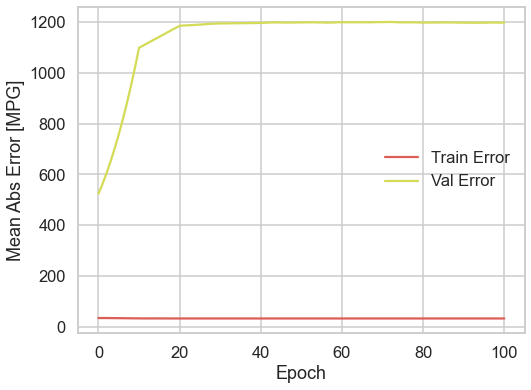

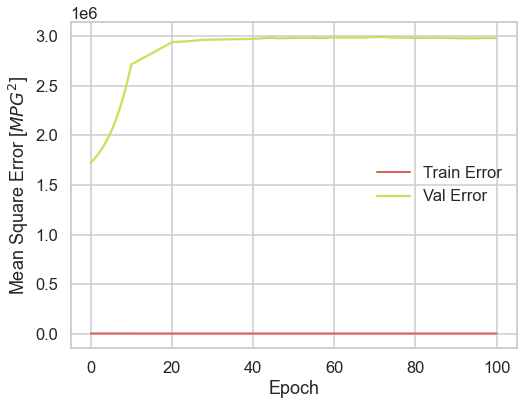

In [166]:
epochs = 400
batch_size = 689
lr = 1e-4
#decay = 1e-6
patience_0 = 100
patience_1 = 10
x = call(input_layer_1)
model = Model(inputs = input_layer_1, outputs = x)
#optimizer =Adam(learning_rate = lr, decay=decay)
optimizer =Adam(learning_rate = lr,epsilon=1)
model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history = model.fit(x=X_train[0],y=y_trains[0], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test[0],y_tests[0]),shuffle = True)
                         #validation_split = 0.5,
plot_history(history)

Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 2s 427us/sample - loss: 1970.9686 - mae: 37.4535 - mse: 1970.4990 - val_loss: 1405230.7500 - val_mae: 63.2234 - val_mse: 14124.3926
Epoch 2/400
5850/5850 [==============================] - 0s 62us/sample - loss: 1955.8814 - mae: 37.2832 - mse: 1955.4116 - val_loss: 1401089.7500 - val_mae: 75.5844 - val_mse: 23369.4688
Epoch 3/400
5850/5850 [==============================] - 0s 62us/sample - loss: 1939.4213 - mae: 37.0840 - mse: 1938.9506 - val_loss: 1406444.6250 - val_mae: 103.9202 - val_mse: 42387.7891
Epoch 4/400
5850/5850 [==============================] - 0s 63us/sample - loss: 1920.4921 - mae: 36.8510 - mse: 1920.0209 - val_loss: 1431338.5000 - val_mae: 149.6755 - val_mse: 79198.2656
Epoch 5/400
5850/5850 [==============================] - 0s 63us/sample - loss: 1901.6828 - mae: 36.6150 - mse: 1901.2109 - val_loss: 1480814.3750 - val_mae: 213.9636 - val_mse: 141639.1094
Epoch 6/

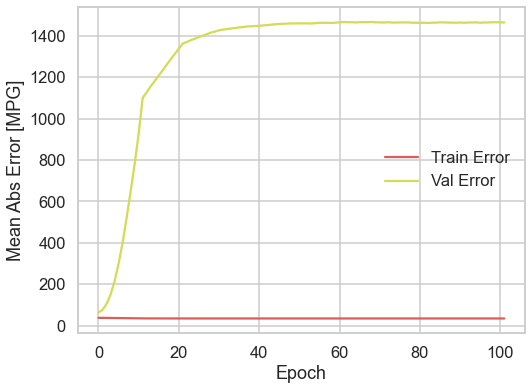

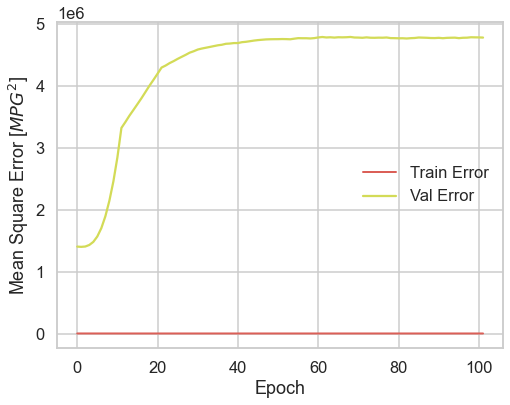

In [167]:
x2 = call(input_layer_2)
model2 = Model(inputs = input_layer_2, outputs = x2)
optimizer =Adam(learning_rate = lr, decay=decay)
model2.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history2 = model2.fit(x=X_train[1],y=y_trains[1], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test[1],y_tests[1]),shuffle = True)
                         #validation_split = 0.5,
plot_history(history2)

Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 2s 422us/sample - loss: 2093.9011 - mae: 38.9529 - mse: 2093.4263 - val_loss: 1583729.1250 - val_mae: 49.8910 - val_mse: 4250.3374
Epoch 2/400
5850/5850 [==============================] - 0s 60us/sample - loss: 2089.9973 - mae: 38.9162 - mse: 2089.5237 - val_loss: 1586200.3750 - val_mae: 51.9702 - val_mse: 4562.8535
Epoch 3/400
5850/5850 [==============================] - 0s 60us/sample - loss: 2083.3707 - mae: 38.8532 - mse: 2082.8975 - val_loss: 1591749.2500 - val_mae: 54.5806 - val_mse: 5015.7129
Epoch 4/400
5850/5850 [==============================] - 0s 60us/sample - loss: 2074.5958 - mae: 38.7658 - mse: 2074.1228 - val_loss: 1601035.6250 - val_mae: 57.7813 - val_mse: 5742.4561
Epoch 5/400
5850/5850 [==============================] - 0s 60us/sample - loss: 2064.3624 - mae: 38.6547 - mse: 2063.8887 - val_loss: 1614770.5000 - val_mae: 62.1476 - val_mse: 7010.0977
Epoch 6/400
5850/

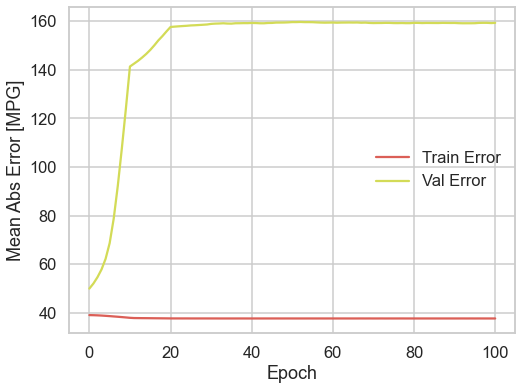

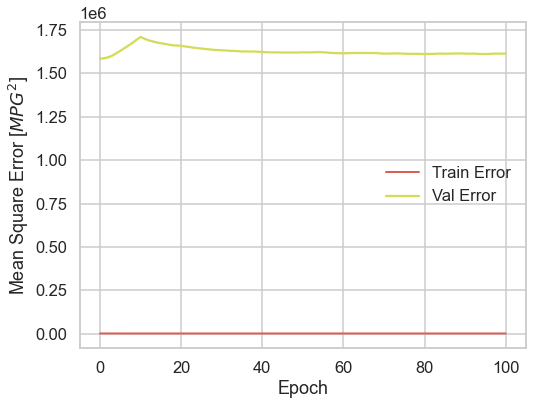

In [168]:
x3 = call(input_layer_3)
model3 = Model(inputs = input_layer_3, outputs = x3)
optimizer =Adam(learning_rate = lr, decay=decay)
model3.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history3 = model3.fit(x=X_train[2],y=y_trains[2], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test[2],y_tests[2]),shuffle = True)
                         #validation_split = 0.5,
plot_history(history3)

Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 3s 492us/sample - loss: 1972.8285 - mae: 37.6438 - mse: 1972.3442 - val_loss: 1275599.1250 - val_mae: 36.9472 - val_mse: 1926.1493
Epoch 2/400
5850/5850 [==============================] - 0s 58us/sample - loss: 1956.3749 - mae: 37.4330 - mse: 1955.8893 - val_loss: 1276005.1250 - val_mae: 36.9472 - val_mse: 1926.1493
Epoch 3/400
5850/5850 [==============================] - 0s 59us/sample - loss: 1939.4596 - mae: 37.2179 - mse: 1938.9718 - val_loss: 1276155.2500 - val_mae: 36.9472 - val_mse: 1926.1493
Epoch 4/400
5850/5850 [==============================] - 0s 61us/sample - loss: 1921.9836 - mae: 36.9978 - mse: 1921.4940 - val_loss: 1275848.6250 - val_mae: 36.9472 - val_mse: 1926.1493
Epoch 5/400
5850/5850 [==============================] - 0s 60us/sample - loss: 1905.1153 - mae: 36.7827 - mse: 1904.6233 - val_loss: 1275299.1250 - val_mae: 36.9472 - val_mse: 1926.1493
Epoch 6/400
5850/

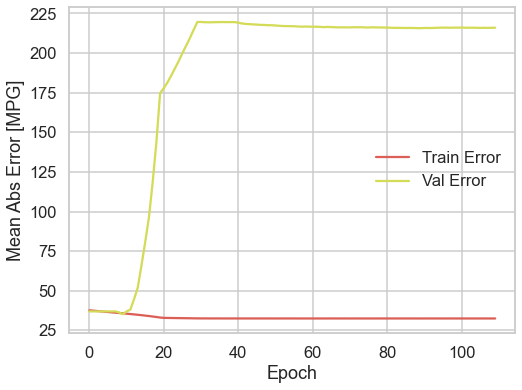

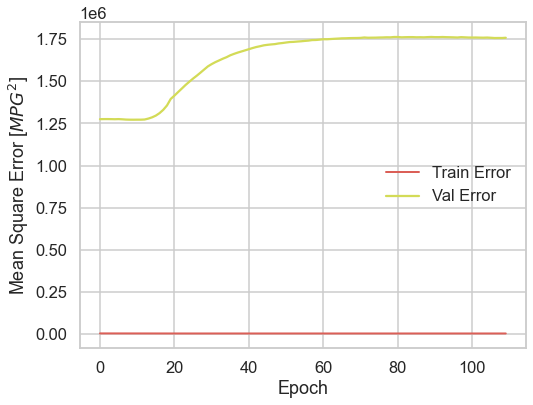

In [169]:
x4 = call(input_layer_4)
model4 = Model(inputs = input_layer_4, outputs = x4)
optimizer =Adam(learning_rate = lr, decay=decay)
model4.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history4 = model4.fit(x=X_train[3],y=y_trains[3], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test[3],y_tests[3]),shuffle = True)
                         #validation_split = 0.5,
plot_history(history4)

Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 2s 423us/sample - loss: 1973.1429 - mae: 37.7413 - mse: 1972.6222 - val_loss: 1793400.0000 - val_mae: 37.2931 - val_mse: 1969.2338
Epoch 2/400
5850/5850 [==============================] - 0s 62us/sample - loss: 1964.3685 - mae: 37.6292 - mse: 1963.8458 - val_loss: 1799038.2500 - val_mae: 37.2931 - val_mse: 1969.2338
Epoch 3/400
5850/5850 [==============================] - 0s 61us/sample - loss: 1955.5438 - mae: 37.5164 - mse: 1955.0189 - val_loss: 1807107.2500 - val_mae: 37.2931 - val_mse: 1969.2338
Epoch 4/400
5850/5850 [==============================] - 0s 62us/sample - loss: 1946.2164 - mae: 37.3998 - mse: 1945.6899 - val_loss: 1813019.7500 - val_mae: 36.2863 - val_mse: 1877.4613
Epoch 5/400
5850/5850 [==============================] - 0s 61us/sample - loss: 1936.8996 - mae: 37.2777 - mse: 1936.3719 - val_loss: 1814192.7500 - val_mae: 36.6213 - val_mse: 2000.9110
Epoch 6/400
5850/

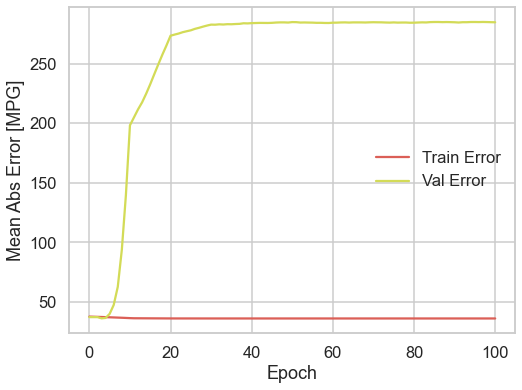

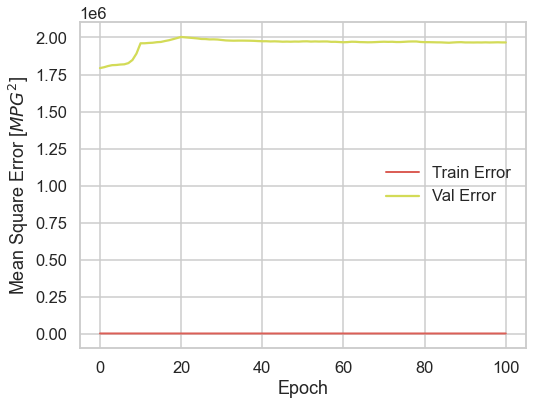

In [170]:
x5 = call(input_layer_5)
model5 = Model(inputs = input_layer_5, outputs = x5)
optimizer =Adam(learning_rate = lr, decay=decay)
model5.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history5 = model5.fit(x=X_train[4],y=y_trains[4], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test[4],y_tests[4]),shuffle = True)
                         #validation_split = 0.5,
plot_history(history5)

In [266]:
model.layers[-8]

In [346]:
model3.layers[t].output

<tf.Tensor 'conv_WEZGIR/Identity:0' shape=(None, 36, 32) dtype=float32>

In [347]:
t = -8
#conca = Concatenate()([model.layers[t].output,model2.layers[t].output,model3.layers[t].output,model4.layers[t].output,model5.layers[t].output])
conca = Concatenate()([model.layers[t].output,model2.layers[t].output])
conca2 = Concatenate()([model3.layers[t].output,model4.layers[t].output])

In [289]:
mergedOut5 = Conv1D(filters = 16, kernel_size = 4)(mergedOut4)
mergedOut5 = AveragePooling1D(pool_size = 4)(mergedOut)
#mergedOut = Flatten()(mergedOut)
mergedOut5 = Dense(1)(mergedOut)



In [305]:
optimizer =Adam(learning_rate = lr, decay=decay)
final_model = Model(inputs = [inputs], outputs=[mergedOut])
#final_model = Model(outputs = mergedOut)
#final_model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])

In [216]:
history = final_model.fit(x=X_train,y=y_trains, batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = patience_0, verbose = 1),ReduceLROnPlateau(patience=patience_1)],           
              validation_data = (X_test,y_tests),shuffle = True)

AttributeError: 'NoneType' object has no attribute 'dtype'

In [ ]:
preds,labels  = test_model(model)
preds = preds.flatten()
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(preds - labels, alpha = 0.8, color = 'r', edgecolor = 'black')

In [99]:
epochs = 400
batch_size = 689
lr = 1e-3
decay = 1e-4
j = -6
k = -4
x = call(input_layer_1)
model = Model(inputs = input_layer_1, outputs = x)
optimizer =Adam(learning_rate = lr, decay=decay)
model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])

In [100]:
history = model.fit(x=X_train[0],y=y_trains[0], batch_size = batch_size, epochs = epochs, verbose = 1,
              callbacks=[EarlyStopping(patience = 20, verbose = 1),ReduceLROnPlateau(patience=10)],           
              validation_data = (X_test[0],y_tests[0]),shuffle = True)
                         #validation_split = 0.5,
model.trainable = False
print(model.summary())

Train on 23400 samples, validate on 156 samples
Epoch 1/400
23400/23400 [==============================] - 2s 96us/sample - loss: 1707.4840 - mae: 34.2044 - mse: 1707.4696 - val_loss: 28918848.0000 - val_mae: 4243.5474 - val_mse: 28902514.0000
Epoch 2/400
23400/23400 [==============================] - 1s 29us/sample - loss: 679.1670 - mae: 20.5572 - mse: 679.1525 - val_loss: 608559744.0000 - val_mae: 20188.4102 - val_mse: 608543424.0000
Epoch 3/400
23400/23400 [==============================] - 1s 28us/sample - loss: 281.7368 - mae: 13.4866 - mse: 281.7223 - val_loss: 2111000704.0000 - val_mae: 36066.6523 - val_mse: 2110984320.0000
Epoch 4/400
23400/23400 [==============================] - 1s 30us/sample - loss: 89.9155 - mae: 7.3280 - mse: 89.9010 - val_loss: 3616908288.0000 - val_mae: 44259.1523 - val_mse: 3616891904.0000
Epoch 5/400
23400/23400 [==============================] - 1s 29us/sample - loss: 39.2481 - mae: 4.8674 - mse: 39.2336 - val_loss: 3967918336.0000 - val_mae: 44970.

In [107]:
x2 = call(input_layer_2, True)
model2 = Model(inputs=[input_layer_1,input_layer_2], outputs = [x,x2])
concatenated = Concatenate(axis=-1)([model.layers[j].output, model2.layers[-4].output])
outputs = Dense(32, activation=activation)(concatenated)
outputs = Dense(16, activation = activation)(outputs)
outputs = Dense(8, activation = activation)(outputs)
outputs = Flatten()(outputs)
outputs = Dense(1, name = 'output')(outputs)


In [108]:
newModel = Model(inputs = [input_layer_1,input_layer_2], outputs = outputs)

In [109]:
optimizer = Adam(learning_rate = lr, decay=decay)
newModel.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history = newModel.fit(x=[X_train[0],X_train[1]],y=[y_trains[0], y_trains[1]], batch_size = batch_size, epochs = epochs, verbose = 1,
      callbacks=[EarlyStopping(patience = 20, verbose = 1),ReduceLROnPlateau(patience=10)],           
      validation_data = ([X_test[0],X_test[1]],[y_tests[0],y_tests[1]]),
                 #validation_split = 0.5,
                 shuffle = True,)
newModel.trainable = False
#print(newModel.summary())

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), for inputs ['output'] but instead got the following list of 2 arrays: [array([[24.36013243],
       [27.65955175],
       [ 1.53569501],
       ...,
       [19.46446755],
       [24.44787532],
       [ 1.77392777]]), array([[41.9085779 ],
       [87.92741818],
       [7...

In [82]:
x = call(input_layer_3, True)
model3 = Model(inputs=[input_layer_1,input_layer_2,input_layer_3], outputs = x)
concatenated = Concatenate(axis=-1)([newModel.layers[j].output, model3.layers[k-1].output])
outputs = Dense(32, activation=activation)(concatenated)
outputs = Dense(16, activation = activation)(outputs)
outputs = Dense(8, activation = activation)(outputs)
outputs = Flatten()(outputs)
outputs = Dense(1, name = 'output')(outputs)


In [83]:
newModel2 = Model(inputs = [input_layer_1,input_layer_2,input_layer_3], outputs = outputs)

In [84]:
optimizer = Adam(learning_rate = lr, decay=decay)
newModel2.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history = newModel2.fit(x=[X_train[0],X_train[1],X_train[2]],y=y_trains[2], batch_size = batch_size, epochs = epochs, verbose = 1,
      callbacks=[EarlyStopping(patience = 20, verbose = 1),ReduceLROnPlateau(patience=10)],           
      validation_data = ([X_test[0],X_test[1],X_test[2]],y_tests[2]),
                 #validation_split = 0.5,
                 shuffle = True,)
#newModel2.trainable = False
print(newModel2.summary())
        

Train on 23400 samples, validate on 156 samples
Epoch 1/1000
23400/23400 [==============================] - 2s 97us/sample - loss: 1719.7671 - mae: 33.9546 - mse: 1719.7528 - val_loss: 16423459.0000 - val_mae: 3745.6006 - val_mse: 16407125.0000
Epoch 2/1000
23400/23400 [==============================] - 1s 32us/sample - loss: 738.0958 - mae: 21.7881 - mse: 738.0813 - val_loss: 164336720.0000 - val_mae: 11986.5391 - val_mse: 164320384.0000
Epoch 3/1000
23400/23400 [==============================] - 1s 30us/sample - loss: 594.9726 - mae: 20.0614 - mse: 594.9581 - val_loss: 176447600.0000 - val_mae: 12695.5078 - val_mse: 176431264.0000
Epoch 4/1000
23400/23400 [==============================] - 1s 32us/sample - loss: 590.0474 - mae: 20.0152 - mse: 590.0329 - val_loss: 181350576.0000 - val_mae: 13037.0947 - val_mse: 181334240.0000
Epoch 5/1000
23400/23400 [==============================] - 1s 31us/sample - loss: 586.6736 - mae: 19.9555 - mse: 586.6591 - val_loss: 181197808.0000 - val_mae: 

In [85]:
x = call(input_layer_4, True)
model4 = Model(inputs=[input_layer_1,input_layer_2,input_layer_3,input_layer_4], outputs = x)
concatenated = Concatenate(axis=-1)([newModel2.layers[j].output, model4.layers[k-2].output])
outputs = Dense(32, activation=activation)(concatenated)
outputs = Dense(16, activation = activation)(outputs)
outputs = Dense(8, activation = activation)(outputs)
outputs = Flatten()(outputs)
outputs = Dense(1, name = 'output')(outputs)
newModel3 = Model(inputs = [input_layer_1,input_layer_2,input_layer_3,input_layer_4], outputs = outputs)

In [86]:
optimizer = Adam(learning_rate = lr, decay=decay)
newModel3.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history = newModel3.fit(x=[X_train[0],X_train[1],X_train[2],X_train[3]],y=y_trains[3], batch_size = batch_size, epochs = epochs, verbose = 1,
      callbacks=[EarlyStopping(patience = 20, verbose = 1),ReduceLROnPlateau(patience=10)],           
      validation_data = ([X_test[0],X_test[1],X_test[2],X_test[3]],y_tests[3]),
                 #validation_split = 0.5,
                 shuffle = True,)
newModel3.trainable = False
print(newModel3.summary())
        

Train on 23400 samples, validate on 156 samples
Epoch 1/1000
23400/23400 [==============================] - 3s 109us/sample - loss: 1412.1701 - mae: 30.3252 - mse: 1412.1555 - val_loss: 214973392.0000 - val_mae: 12822.3936 - val_mse: 214957056.0000
Epoch 2/1000
23400/23400 [==============================] - 1s 33us/sample - loss: 577.5009 - mae: 19.8454 - mse: 577.4863 - val_loss: 517813536.0000 - val_mae: 19994.1172 - val_mse: 517797216.0000
Epoch 3/1000
23400/23400 [==============================] - 1s 33us/sample - loss: 540.8926 - mae: 19.3068 - mse: 540.8781 - val_loss: 764830656.0000 - val_mae: 24383.4453 - val_mse: 764814336.0000
Epoch 4/1000
23400/23400 [==============================] - 1s 33us/sample - loss: 526.3233 - mae: 18.9869 - mse: 526.3089 - val_loss: 932662912.0000 - val_mae: 26882.6855 - val_mse: 932646592.0000
Epoch 5/1000
23400/23400 [==============================] - 1s 33us/sample - loss: 515.0479 - mae: 18.6921 - mse: 515.0334 - val_loss: 987056640.0000 - val_m

KeyboardInterrupt: 

In [ ]:
x = call(input_layer_5, True)
model5 = Model(inputs=[input_layer_1,input_layer_2,input_layer_3,input_layer_4,input_layer_5], outputs = x)


In [ ]:
concatenated = Concatenate(axis=-1)([newModel3.layers[j].output, model5.layers[k-3].output])
outputs = Dense(32, activation=activation)(concatenated)
outputs = Dense(16, activation = activation)(outputs)
outputs = Dense(8, activation = activation)(outputs)
outputs = Flatten()(outputs)
outputs = Dense(1, name = 'output')(outputs)
newModel4 = Model(inputs = [input_layer_1,input_layer_2,input_layer_3,input_layer_4,input_layer_5], outputs = outputs)

In [68]:
epochs = 1000
optimizer = Adam(learning_rate = lr, decay = decay)
newModel4.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
history = newModel4.fit(x=[X_train[0],X_train[1],X_train[2],X_train[3],X_train[4]],y=y_train, batch_size = batch_size, epochs = epochs, verbose = 1,
      callbacks=[EarlyStopping(patience = 20, verbose = 1),ReduceLROnPlateau(patience=10)],           
      validation_data = ([X_test[0],X_test[1],X_test[2],X_test[3],X_test[4]],y_test),
                 #validation_split = 0.5,
                 shuffle = True,)
        
print(newModel4.summary())

Train on 23400 samples, validate on 156 samples
Epoch 1/1000
23400/23400 [==============================] - 3s 121us/sample - loss: 853.4691 - mae: 22.8342 - mse: 853.4545 - val_loss: 4478107136.0000 - val_mae: 42995.6172 - val_mse: 4478090752.0000
Epoch 2/1000
23400/23400 [==============================] - 1s 37us/sample - loss: 83.8331 - mae: 7.2945 - mse: 83.8186 - val_loss: 4643769856.0000 - val_mae: 48849.6875 - val_mse: 4643753472.0000
Epoch 3/1000
23400/23400 [==============================] - 1s 37us/sample - loss: 41.6973 - mae: 5.0271 - mse: 41.6829 - val_loss: 5214803968.0000 - val_mae: 52406.1836 - val_mse: 5214787584.0000
Epoch 4/1000
23400/23400 [==============================] - 1s 35us/sample - loss: 34.9357 - mae: 4.5584 - mse: 34.9212 - val_loss: 5491943424.0000 - val_mae: 53573.5898 - val_mse: 5491927040.0000
Epoch 5/1000
23400/23400 [==============================] - 1s 37us/sample - loss: 32.6900 - mae: 4.4039 - mse: 32.6755 - val_loss: 5656513024.0000 - val_mae: 5

In [69]:
from tensorflow.keras.utils import plot_model

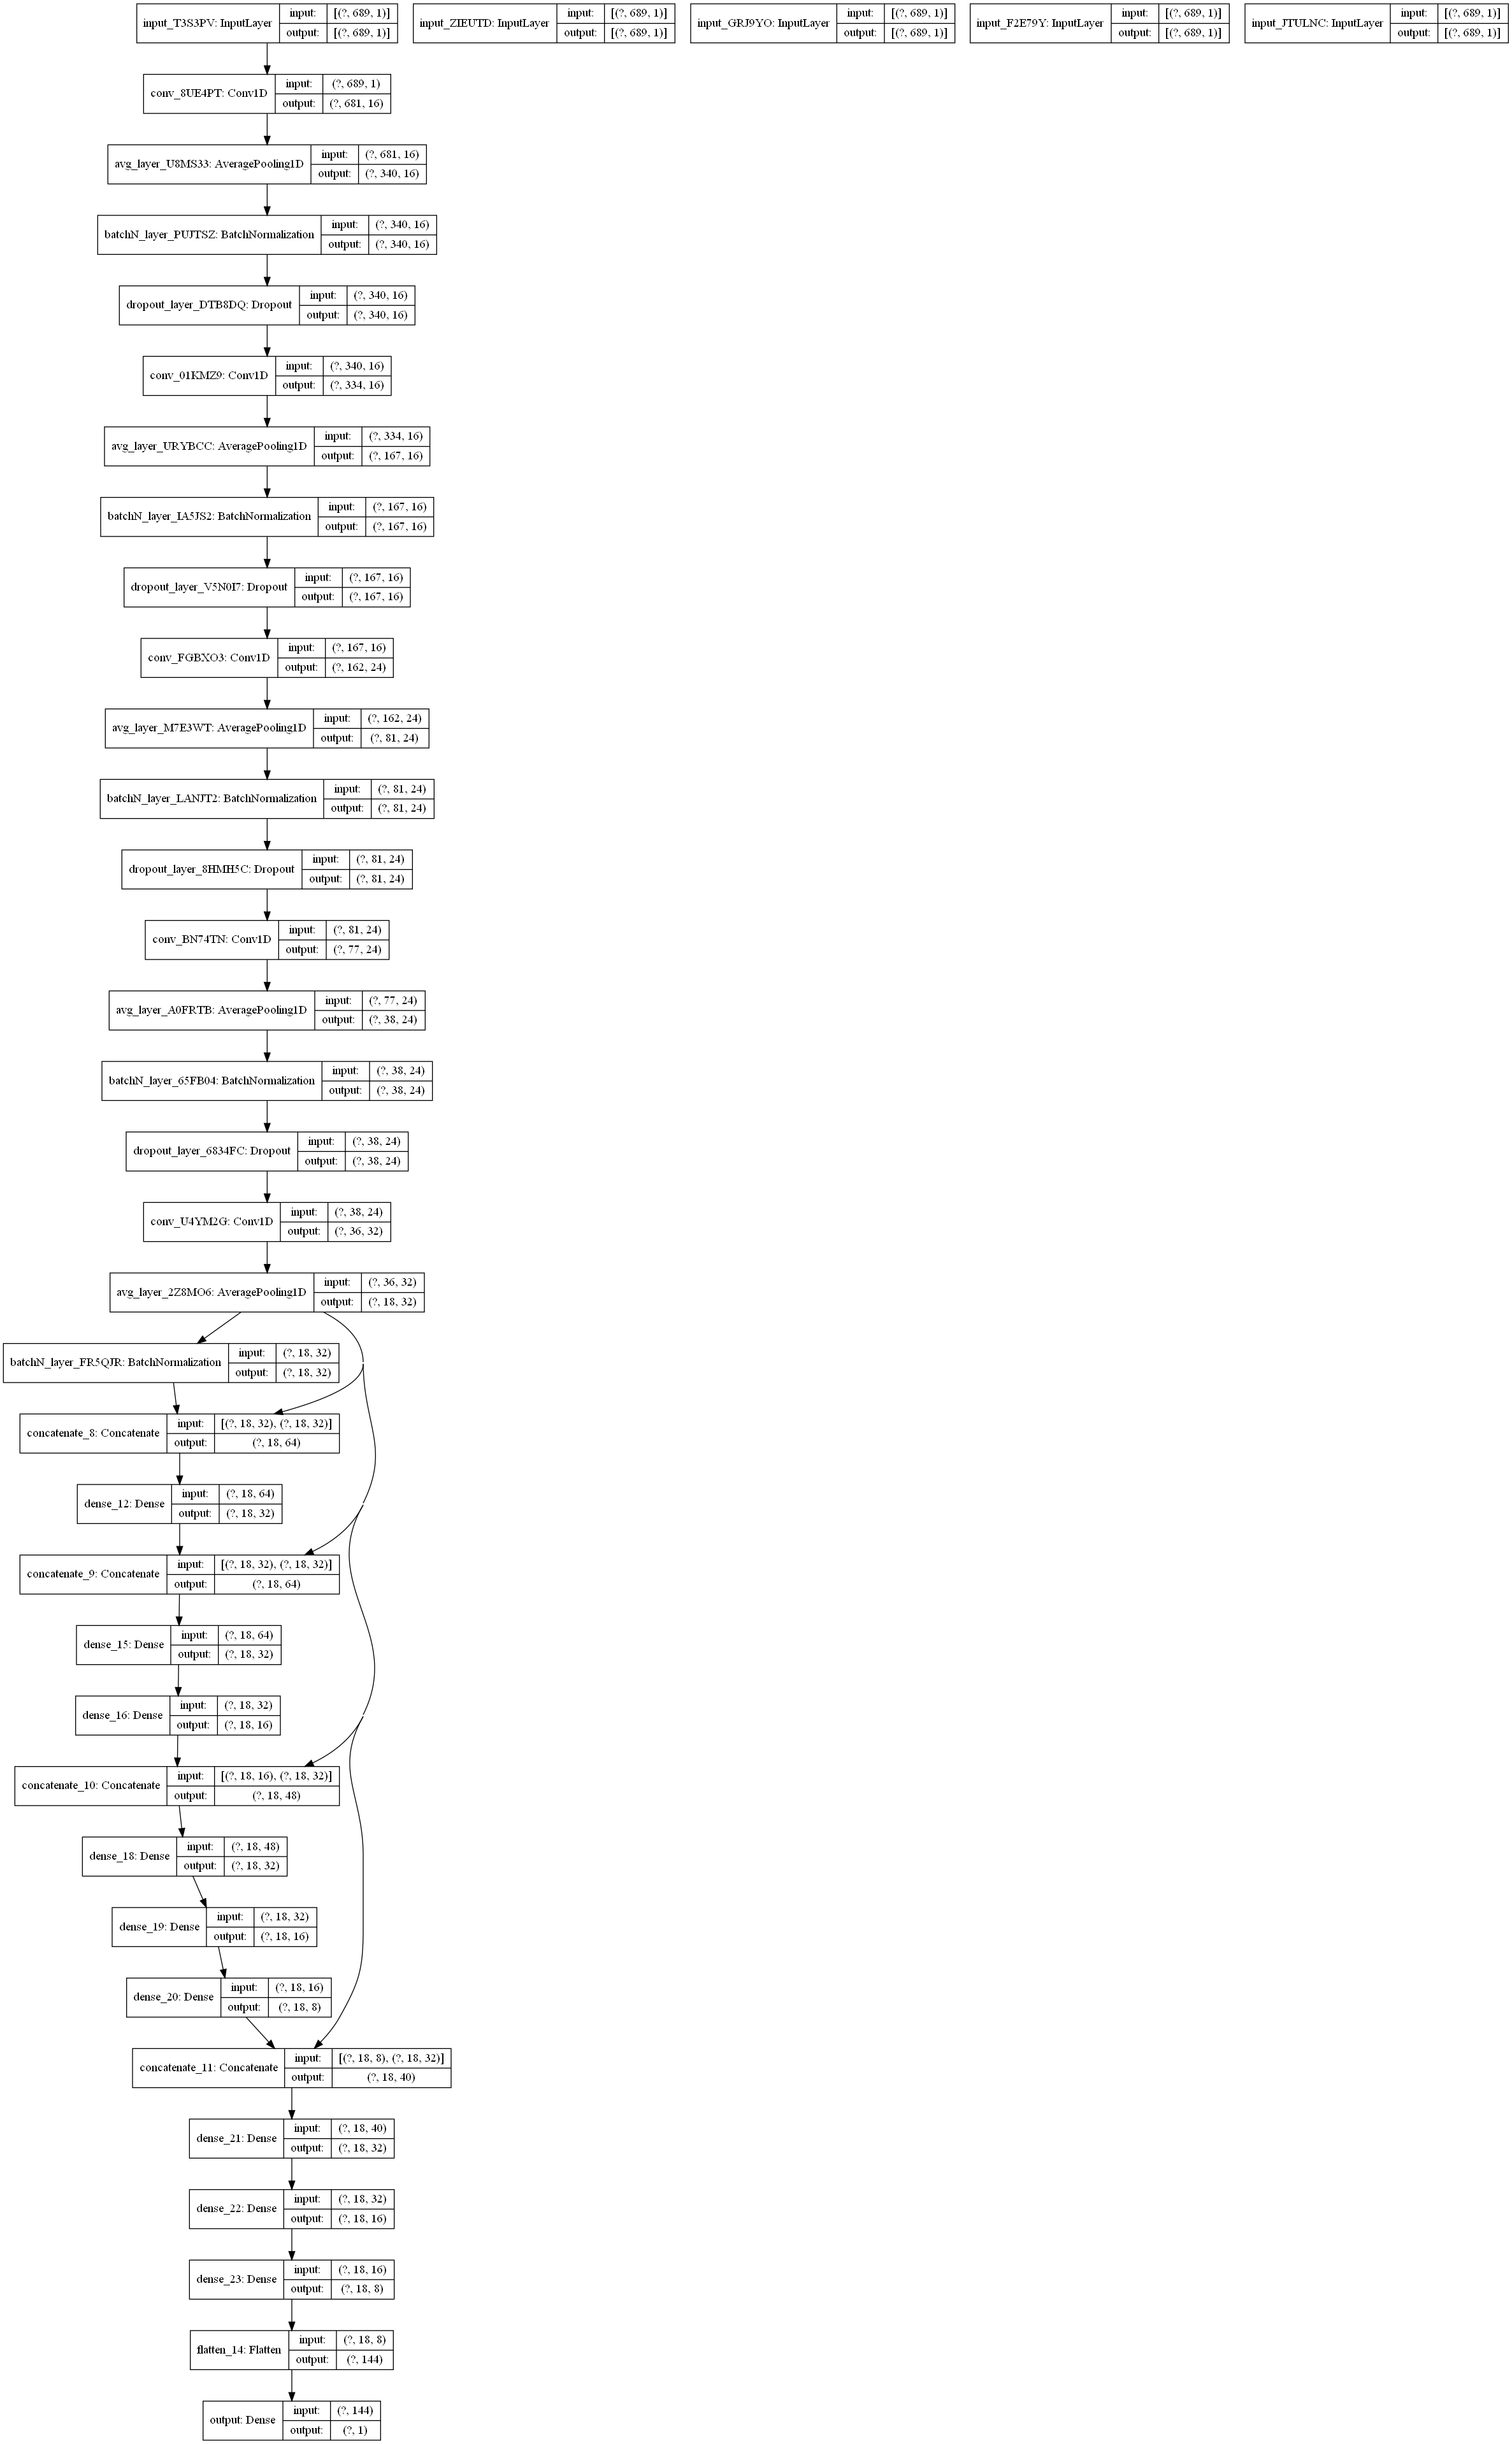

In [70]:
plot_model(newModel4,show_shapes=True,expand_nested=True)

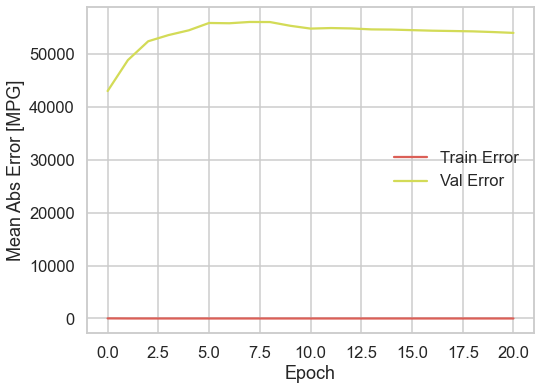

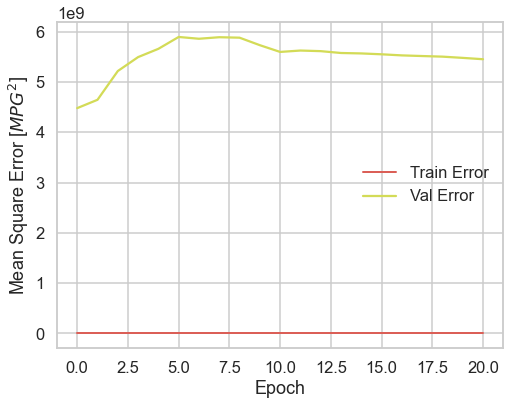

In [71]:
plot_history(history)

In [128]:
activation = 'relu'

X_train_1, X_test_1, y_train_1, y_test_1, info_1 = prepare_data_training(0)
X_train_2, X_test_2, y_train_2, y_test_2, info_2 = prepare_data_training(5)
X_train_3, X_test_3, y_train_3, y_test_3, info_3 = prepare_data_training(10)
X_train_4, X_test_4, y_train_4, y_test_4, info_4 = prepare_data_training(15)
X_train_5, X_test_5, y_train_5, y_test_5, info_5 = prepare_data_training(20)
n_features = 689
j = 2

Levou 3.31 segundos para finalizar a adição de ruído.
Levou 3.34 segundos para finalizar a adição de ruído.
Levou 3.65 segundos para finalizar a adição de ruído.
Levou 3.57 segundos para finalizar a adição de ruído.
Levou 3.44 segundos para finalizar a adição de ruído.


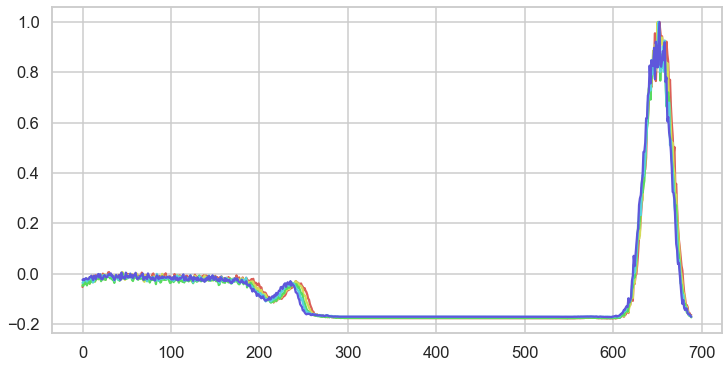

In [129]:
n = 888
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(X_train_1[n], label = 'M1')
ax.plot(X_train_2[n], label = 'M2')
ax.plot(X_train_3[n], label = 'M3')
ax.plot(X_train_4[n], label = 'M4')
ax.plot(X_train_5[n], label = 'M5')

In [147]:


input1 = np.expand_dims(X_train_1,1)
input_layer_1 = Input(shape=(X_train_1.shape[1],1), name = 'input_1')

input2 = np.expand_dims(X_train_2,1)
input_layer_2 = Input(shape=(X_train_2.shape[1],1), name = 'input_2')

input3 = np.expand_dims(X_train_3,1)
input_layer_3 = Input(shape=(X_train_3.shape[1],1), name = 'input_3')

input4 = np.expand_dims(X_train_4,1)
input_layer_4 = Input(shape=(X_train_4.shape[1],1), name = 'input_4')

input5 = np.expand_dims(X_train_5,1)
input_layer_5 = Input(shape=(X_train_5.shape[1],1), name = 'input_5')

inputs = [input_layer_1,input_layer_2,input_layer_3,input_layer_4,input_layer_5]


#-----------------first-model-to-lower-angles-------------------------------------------------#
#first_conv1d_layer = Conv1D(filters = 8, kernel_size = 4, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(input_layer_1)
first_conv1d_layer = Conv1D(filters = 6, kernel_size = 9, activation = activation)(input_layer_1)
avg_pool1d_layer_1 = AveragePooling1D()(first_conv1d_layer)
batchNorm_layer_1 = BatchNormalization()(avg_pool1d_layer_1)
dropout_layer_1 = Dropout(0.004)(batchNorm_layer_1)

#first_conv1d_layer_2 = Conv1D(filters = 8, kernel_size = 4, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_1)
first_conv1d_layer_2 = Conv1D(filters = 6, kernel_size = 7, activation = activation)(dropout_layer_1)
avg_pool1d_layer_1_2 = AveragePooling1D()(first_conv1d_layer_2)
batchNorm_layer_1_2 = BatchNormalization()(avg_pool1d_layer_1_2)
dropout_layer_1_2 = Dropout(0.004)(batchNorm_layer_1_2)

#first_conv1d_layer_3 = Conv1D(filters = 4, kernel_size = 2, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_1_2)
first_conv1d_layer_3 = Conv1D(filters = 4, kernel_size = 4, activation = activation)(dropout_layer_1_2)
#avg_pool1d_layer_1_3 = AveragePooling1D()(first_conv1d_layer_3)
#batchNorm_layer_1_3 = BatchNormalization()(avg_pool1d_layer_1_3)
batchNorm_layer_1_3 = BatchNormalization()(first_conv1d_layer_3)
global_pool1d_layer_1 = GlobalAveragePooling1D()(batchNorm_layer_1_3)

dense_1 = Dense(4, activation=activation)(global_pool1d_layer_1)

#---------------------------------------------------------------------------------------------#
#----------------second-model-to-lower+-angles------------------------------------------------#
#second_conv1d_layer = Conv1D(filters = 8, kernel_size = 3, activation=activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(input_layer_2)
second_conv1d_layer = Conv1D(filters = 6, kernel_size = 7, activation=activation)(input_layer_2)
avg_pool1d_layer_2 = AveragePooling1D()(second_conv1d_layer)
batchNorm_layer_2 = BatchNormalization()(avg_pool1d_layer_2)
dropout_layer_2 = Dropout(0.004)(batchNorm_layer_2)

#second_conv1d_layer_2 = Conv1D(filters = 8, kernel_size = 2, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_2)
second_conv1d_layer_2 = Conv1D(filters = 6, kernel_size = 5, activation = activation)(dropout_layer_2)
avg_pool1d_layer_2_2 = AveragePooling1D()(second_conv1d_layer_2)
batchNorm_layer_2_2 = BatchNormalization()(avg_pool1d_layer_2_2)
dropout_layer_2_2 = Dropout(0.004)(batchNorm_layer_2_2)

#second_conv1d_layer_3 = Conv1D(filters = 4, kernel_size = 1, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_2_2)
second_conv1d_layer_3 = Conv1D(filters = 4, kernel_size = 3, activation = activation)(dropout_layer_2_2)
#avg_pool1d_layer_2_3 = AveragePooling1D()(second_conv1d_layer_3)
#batchNorm_layer_2_3 = BatchNormalization()(avg_pool1d_layer_2_3)
batchNorm_layer_2_3 = BatchNormalization()(second_conv1d_layer_3)
global_pool1d_layer_2 = GlobalAveragePooling1D()(batchNorm_layer_2_3)

dense_2 = Dense(4, activation=activation)(global_pool1d_layer_2)

#---------------------------------------------------------------------------------------------#
#----------------third-model-to-medium-angles-------------------------------------------------#
#third_conv1d_layer = Conv1D(filters = 12, kernel_size = 8, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(input_layer_3)
third_conv1d_layer = Conv1D(filters = 8, kernel_size = 8, activation = activation)(input_layer_3)
avg_pool1d_layer_3 = AveragePooling1D()(third_conv1d_layer)
batchNorm_layer_3 = BatchNormalization()(avg_pool1d_layer_3)
dropout_layer_3 = Dropout(0.004)(batchNorm_layer_3)

#third_conv1d_layer_2 = Conv1D(filters = 12, kernel_size = 8, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_3)
third_conv1d_layer_2 = Conv1D(filters = 8, kernel_size = 6, activation = activation)(dropout_layer_3)
avg_pool1d_layer_3_2 = AveragePooling1D()(third_conv1d_layer_2)
batchNorm_layer_3_2 = BatchNormalization()(avg_pool1d_layer_3_2)
dropout_layer_3_2 = Dropout(0.004)(batchNorm_layer_3_2)

#third_conv1d_layer_3 = Conv1D(filters = 6, kernel_size = 4, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_3_2)
third_conv1d_layer_3 = Conv1D(filters = 3, kernel_size = 5, activation = activation)(dropout_layer_3_2)
#avg_pool1d_layer_3_3 = AveragePooling1D()(third_conv1d_layer_3)
#batchNorm_layer_3_3 = BatchNormalization()(avg_pool1d_layer_3_3)
batchNorm_layer_3_3 = BatchNormalization()(third_conv1d_layer_3)
global_pool1d_layer_3 = GlobalAveragePooling1D()(batchNorm_layer_3_3)

dense_3 = Dense(4, activation = activation)(global_pool1d_layer_3)
#----------------------------------------------------------------------------------------------#
#----------------fourth-model-to-medium+-angles------------------------------------------------#
#fourth_conv1d_layer = Conv1D(filters = 12, kernel_size = 6, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(input_layer_4)
fourth_conv1d_layer = Conv1D(filters = 8, kernel_size = 6, activation = activation)(input_layer_4)
avg_pool1d_layer_4 = AveragePooling1D()(fourth_conv1d_layer)
batchNorm_layer_4 = BatchNormalization()(avg_pool1d_layer_4)
dropout_layer_4 = Dropout(0.004)(batchNorm_layer_4)

#fourth_conv1d_layer_2 = Conv1D(filters = 12, kernel_size = 6, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_4)
fourth_conv1d_layer_2 = Conv1D(filters = 8, kernel_size = 4, activation = activation)(dropout_layer_4)
avg_pool1d_layer_4_2 = AveragePooling1D()(fourth_conv1d_layer_2)
batchNorm_layer_4_2 = BatchNormalization()(avg_pool1d_layer_4_2)
dropout_layer_4_2 = Dropout(0.004)(batchNorm_layer_4_2)

#fourth_conv1d_layer_3 = Conv1D(filters = 6, kernel_size = 1, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_4_2)
fourth_conv1d_layer_3 = Conv1D(filters = 3, kernel_size = 4, activation = activation)(dropout_layer_4_2)
avg_pool1d_layer_4_3 = AveragePooling1D()(fourth_conv1d_layer_3)
#batchNorm_layer_4_3 = BatchNormalization()(avg_pool1d_layer_4_3)
batchNorm_layer_4_3 = BatchNormalization()(fourth_conv1d_layer_3)
global_pool1d_layer_4 = GlobalAveragePooling1D()(batchNorm_layer_4_3)

dense_4 = Dense(4, activation=activation)(global_pool1d_layer_4)
#---------------------------------------------------------------------------------------------#
#----------------fifth-model-to-higher-angles-------------------------------------------------#
#fifth_conv1d_layer = Conv1D(filters = 16, kernel_size = 12, activation = activation, kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(input_layer_5)
fifth_conv1d_layer = Conv1D(filters = 12, kernel_size = 7, activation = activation)(input_layer_5)
avg_pool1d_layer_5 = AveragePooling1D()(fifth_conv1d_layer)
batchNorm_layer_5 = BatchNormalization()(avg_pool1d_layer_5)
dropout_layer_5 = Dropout(0.004)(batchNorm_layer_5)

#fifth_conv1d_layer_2 = Conv1D(filters = 16, kernel_size = 8, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_5)
fifth_conv1d_layer_2 = Conv1D(filters = 12, kernel_size = 5, activation = activation)(dropout_layer_5)
avg_pool1d_layer_5_2 = AveragePooling1D()(fifth_conv1d_layer_2)
batchNorm_layer_5_2 = BatchNormalization()(avg_pool1d_layer_5_2)
dropout_layer_5_2 = Dropout(0.004)(batchNorm_layer_5_2)

#fifth_conv1d_layer_3 = Conv1D(filters = 8, kernel_size = 4, activation = activation,kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(dropout_layer_5_2)
fifth_conv1d_layer_3 = Conv1D(filters = 4, kernel_size = 2, activation = activation)(dropout_layer_5_2)
#avg_pool1d_layer_5_3 = AveragePooling1D()(fifth_conv1d_layer_3)
#batchNorm_layer_5_3 = BatchNormalization()(avg_pool1d_layer_5_3)
batchNorm_layer_5_3 = BatchNormalization()(fifth_conv1d_layer_3)
global_pool1d_layer_5 = GlobalAveragePooling1D()(batchNorm_layer_5_3)
                                           
dense_5 = Dense(4, activation=activation)(global_pool1d_layer_5)
#---------------------------------------------------------------------------------------------#
#--------------------merge-the-input-models-into-a-single-large-vector------------------------#
concatenated = Concatenate()([dense_1, dense_2, dense_3, dense_4, dense_5])
#---------------------------------------------------------------------------------------------#
#---------------------------apply-final-output-with-mix-models--------------------------------#
#outputs = Dense(6, activation=activation, kernel_regularizer=regularizers.l1_l2(l1 = 0.01, l2 = 0.02))(concatenated)
outputs = Dense(45, activation=activation)(concatenated)
outputs = BatchNormalization(axis = 1)(outputs)
outputs = Dense(35, activation = activation)(outputs)
outputs = BatchNormalization(axis = 1)(outputs)
outputs = Dense(15, activation = activation)(outputs)
outputs = BatchNormalization(axis = 1)(outputs)
outputs = Dense(1, name = 'output')(outputs)

lr = 1e-6
model_ = Model(inputs = inputs, outputs = outputs)
optimizer = Adam(learning_rate = lr, decay=decay)
model_.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
#print(model_.summary())
#plot_model(model_,to_file="modelo_teste.png")
history = model_.fit(x=[X_train_1,X_train_2,X_train_3,X_train_4,X_train_5],y=y_train_1, batch_size = 689, epochs =1000, verbose = 1,
          callbacks=[EarlyStopping(patience = 40, verbose = 1),ReduceLROnPlateau(patience=4)],           
          validation_data = ([X_test_1,X_test_2,X_test_3,X_test_4,X_test_5], y_test_1),
#                     validation_split = 0.3,
                     shuffle = True,)
plot_model(model_,show_shapes=True,expand_nested=True)
plot_history(history)

Train on 5850 samples, validate on 156 samples
Epoch 1/1000
5850/5850 [==============================] - 7s 1ms/sample - loss: 1934.5590 - mae: 37.1091 - mse: 1934.5590 - val_loss: 1762.6769 - val_mae: 35.0619 - val_mse: 1762.6769
Epoch 2/1000
5850/5850 [==============================] - 1s 122us/sample - loss: 1934.3907 - mae: 37.1106 - mse: 1934.3906 - val_loss: 1719.8594 - val_mae: 34.5364 - val_mse: 1719.8594
Epoch 3/1000
5850/5850 [==============================] - 1s 122us/sample - loss: 1934.2747 - mae: 37.1100 - mse: 1934.2747 - val_loss: 1668.6754 - val_mae: 33.8923 - val_mse: 1668.6754
Epoch 4/1000
5850/5850 [==============================] - 1s 122us/sample - loss: 1934.3492 - mae: 37.1100 - mse: 1934.3492 - val_loss: 1608.3914 - val_mae: 33.1145 - val_mse: 1608.3914
Epoch 5/1000
5850/5850 [==============================] - 1s 121us/sample - loss: 1934.2247 - mae: 37.1094 - mse: 1934.2247 - val_loss: 1538.9199 - val_mae: 32.2312 - val_mse: 1538.9199
Epoch 6/1000
5850/5850 [=

KeyboardInterrupt: 

In [ ]:
preds,labels  = test_model(newModel4)

In [ ]:
preds = preds.flatten()

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(preds - labels, alpha = 0.8, color = 'r', edgecolor = 'black')



In [143]:
labels

array([34.17727217, 34.17727217, 34.17727217, 34.17727217, 34.17727217,
       66.6950584 , 66.6950584 , 66.6950584 , 66.6950584 , 66.6950584 ,
       16.66411305, 16.66411305, 16.66411305, 16.66411305, 16.66411305,
       16.40395207, 16.40395207, 16.40395207, 16.40395207, 16.40395207,
       55.56046255, 55.56046255, 55.56046255, 55.56046255, 55.56046255,
       63.78736235, 63.78736235, 63.78736235, 63.78736235, 63.78736235,
       42.97742439, 42.97742439, 42.97742439, 42.97742439, 42.97742439])

In [144]:
preds

array([-717.36554, -763.86993, -763.4407 , -759.86115, -755.50024,
       -704.78174, -747.30536, -747.38745, -743.1936 , -740.1453 ,
       -712.03534, -754.76764, -754.6287 , -752.9394 , -749.4584 ,
       -708.5559 , -752.2624 , -750.32275, -745.7912 , -741.1201 ,
       -647.2161 , -688.5546 , -686.4278 , -680.3351 , -675.72754,
        195.1691 ,  211.71828,  219.94316,  225.06049,  232.62016,
       -641.41943, -679.46436, -676.0314 , -670.6253 , -668.1055 ],
      dtype=float32)

Levou 1.05 segundos para finalizar a adição de ruído.
Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 3s 437us/sample - loss: 1969.7325 - mae: 37.6829 - mse: 1969.7196 - val_loss: 1681.8193 - val_mae: 33.6300 - val_mse: 1653.0062
Epoch 2/400
5850/5850 [==============================] - 0s 51us/sample - loss: 1962.8090 - mae: 37.5912 - mse: 1962.7959 - val_loss: 1408.0256 - val_mae: 30.4008 - val_mse: 1372.9296
Epoch 3/400
5850/5850 [==============================] - 0s 58us/sample - loss: 1954.7713 - mae: 37.4892 - mse: 1954.7579 - val_loss: 1143.6033 - val_mae: 26.9229 - val_mse: 1099.5533
Epoch 4/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1946.4106 - mae: 37.3838 - mse: 1946.3971 - val_loss: 897.1271 - val_mae: 23.5035 - val_mse: 841.7023
Epoch 5/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1937.8803 - mae: 37.2715 - mse: 1937.8663 - val_loss: 691.7109 - val_mae: 19.8391 - 

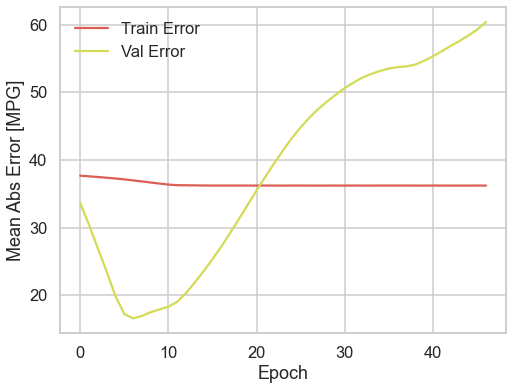

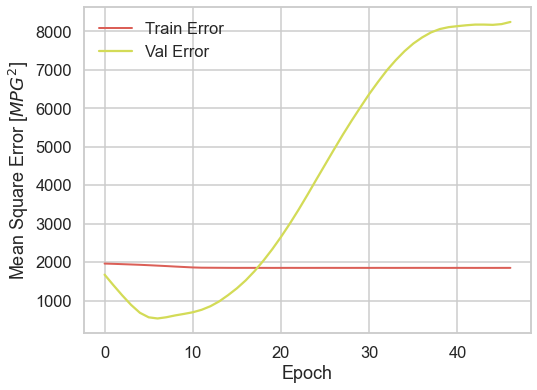

Levou 1.06 segundos para finalizar a adição de ruído.
Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1751.2600 - mae: 34.9056 - mse: 1751.2422 - val_loss: 7474.5137 - val_mae: 60.0114 - val_mse: 5151.6743
Epoch 2/400
5850/5850 [==============================] - 0s 54us/sample - loss: 1750.5212 - mae: 34.8966 - mse: 1750.5034 - val_loss: 7740.9761 - val_mae: 62.2082 - val_mse: 5344.8452
Epoch 3/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1750.6337 - mae: 34.8993 - mse: 1750.6158 - val_loss: 8062.4580 - val_mae: 64.5672 - val_mse: 5593.8984
Epoch 4/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1750.8293 - mae: 34.8996 - mse: 1750.8116 - val_loss: 8444.3965 - val_mae: 67.0303 - val_mse: 5904.0664
Epoch 5/400
5850/5850 [==============================] - 0s 54us/sample - loss: 1750.7925 - mae: 34.9025 - mse: 1750.7749 - val_loss: 8891.3457 - val_mae: 69.6569 

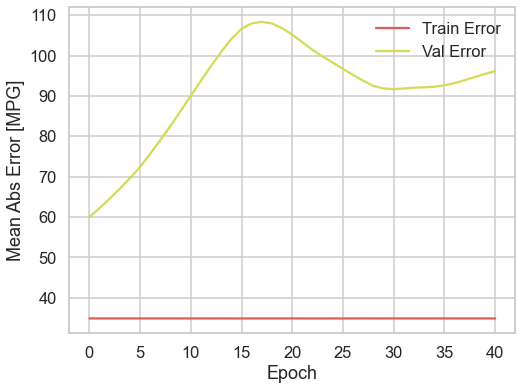

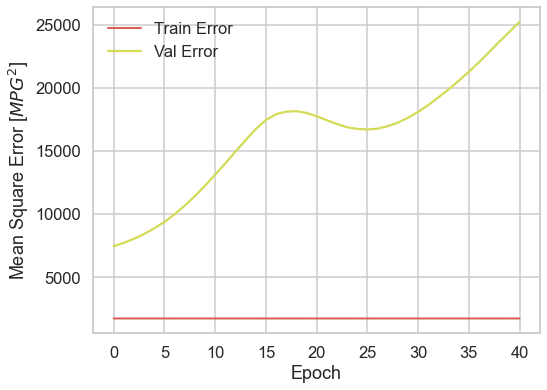

Levou 0.98 segundos para finalizar a adição de ruído.
Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1875.4072 - mae: 36.1084 - mse: 1875.3895 - val_loss: 30124.8105 - val_mae: 106.0621 - val_mse: 24133.5312
Epoch 2/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1875.6384 - mae: 36.1109 - mse: 1875.6208 - val_loss: 30939.7383 - val_mae: 106.9069 - val_mse: 24891.0293
Epoch 3/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1875.2947 - mae: 36.1092 - mse: 1875.2770 - val_loss: 31733.4316 - val_mae: 107.6564 - val_mse: 25629.5098
Epoch 4/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1875.1443 - mae: 36.1071 - mse: 1875.1265 - val_loss: 32498.4219 - val_mae: 108.3924 - val_mse: 26341.1133
Epoch 5/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1875.3590 - mae: 36.1079 - mse: 1875.3411 - val_loss: 33241.4141 - val_

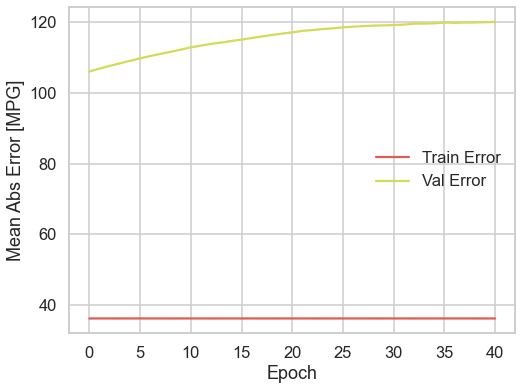

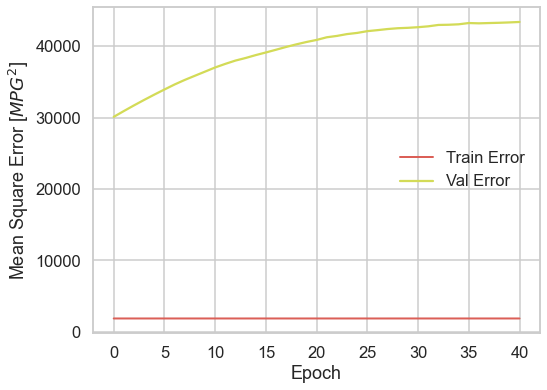

Levou 0.97 segundos para finalizar a adição de ruído.
Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 0s 56us/sample - loss: 1859.3324 - mae: 35.8168 - mse: 1859.3148 - val_loss: 44880.6953 - val_mae: 127.7420 - val_mse: 37502.2109
Epoch 2/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1859.3336 - mae: 35.8153 - mse: 1859.3159 - val_loss: 44804.5312 - val_mae: 127.6564 - val_mse: 37388.6250
Epoch 3/400
5850/5850 [==============================] - 0s 55us/sample - loss: 1859.5115 - mae: 35.8174 - mse: 1859.4937 - val_loss: 44731.0859 - val_mae: 127.5704 - val_mse: 37280.3906
Epoch 4/400
5850/5850 [==============================] - 0s 54us/sample - loss: 1859.8190 - mae: 35.8211 - mse: 1859.8014 - val_loss: 44743.5820 - val_mae: 127.6064 - val_mse: 37257.2500
Epoch 5/400
5850/5850 [==============================] - 0s 54us/sample - loss: 1859.6718 - mae: 35.8210 - mse: 1859.6541 - val_loss: 44737.5742 - val_

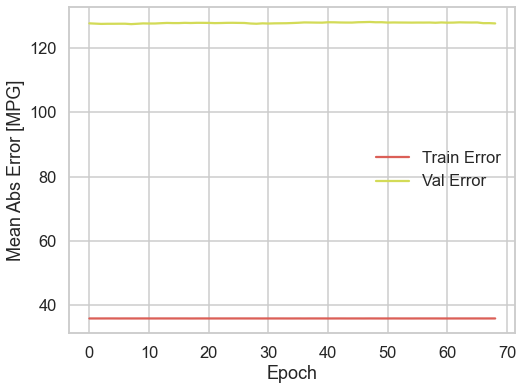

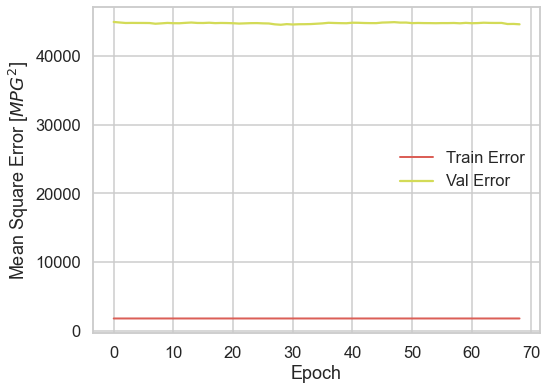

Levou 1.02 segundos para finalizar a adição de ruído.
Train on 5850 samples, validate on 156 samples
Epoch 1/400
5850/5850 [==============================] - 0s 54us/sample - loss: 1886.5888 - mae: 36.2383 - mse: 1886.5709 - val_loss: 39740.5117 - val_mae: 113.2761 - val_mse: 32683.1348
Epoch 2/400
5850/5850 [==============================] - 0s 53us/sample - loss: 1886.4565 - mae: 36.2367 - mse: 1886.4390 - val_loss: 39377.8633 - val_mae: 112.7554 - val_mse: 32367.0762
Epoch 3/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1886.7088 - mae: 36.2410 - mse: 1886.6909 - val_loss: 38989.4453 - val_mae: 112.2085 - val_mse: 32024.6660
Epoch 4/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1886.3285 - mae: 36.2366 - mse: 1886.3105 - val_loss: 38700.6836 - val_mae: 111.7894 - val_mse: 31773.9492
Epoch 5/400
5850/5850 [==============================] - 0s 52us/sample - loss: 1886.7345 - mae: 36.2403 - mse: 1886.7168 - val_loss: 38401.3047 - val_

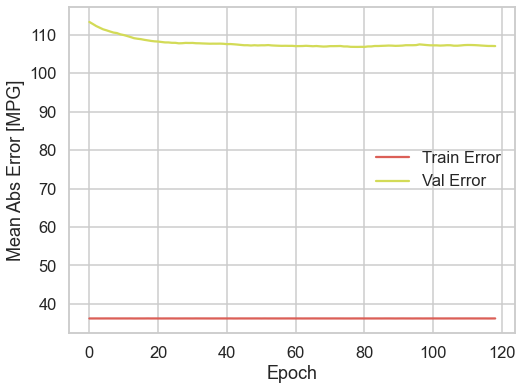

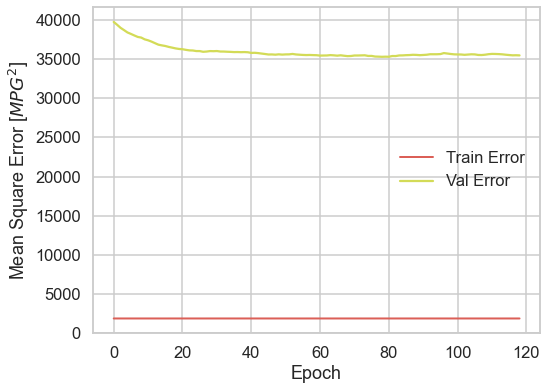

In [381]:
n_features = 689
models = [functional_conv_model(n_features,lr,decay)]*5
n = 0
path_save_weights = "data_barbara/highest_val_mae_weights_epoch{epoch:02d}-val_mae{val_mae:.3f}_cnn.h5"
histories = []
for i in range(5):
    X_train, X_test, y_train, y_test,_ = prepare_data_training(n)
    #hist = train_model(models[i],X_train,X_test,y_train,y_test,path_to_save = path_save_weights,epochs = 150, batch_size = 300)
    history = models[i].fit(x=X_train,y=y_train, batch_size = 689, epochs =400, verbose = 1,
          callbacks=[EarlyStopping(patience = 40, verbose = 1),ReduceLROnPlateau(patience=4)],           
          validation_data = (X_test, y_test),
#                     validation_split = 0.3,
                     shuffle = True,)
    histories.append(history)
    plot_history(history)
    n+=5

In [17]:
#mergedOut = Add()([models[0].layers[-j].output, models[1].layers[-j].output, models[2].layers[-j].output,models[3].layers[-j].output,models[4].layers[-j].output])
#mergedOut = Conv1D(filters = 18, kernel_size =2)(mergedOut)

In [33]:
for m in models:
    i = 0
    for l in m.layers:
        if i == 21:
            
            l.trainable = False
        i+=1

In [382]:
models[0].trainable = False
models[1].trainable = False
models[2].trainable = False
models[3].trainable = False
models[4].trainable = False

In [383]:


X_train_1, X_test_1, y_train_1, y_test_1,_ = prepare_data_training(0)
X_train_2, X_test_2, y_train_2, y_test_2,_ = prepare_data_training(5)
X_train_3, X_test_3, y_train_3, y_test_3,_ = prepare_data_training(10)
X_train_4, X_test_4, y_train_4, y_test_4,_ = prepare_data_training(15)
X_train_5, X_test_5, y_train_5, y_test_5,_ = prepare_data_training(20)

n_features = 689
#models = [conv_model(n_features),conv_model(n_features),conv_model(n_features),conv_model(n_features),conv_model(n_features)]
#models = [gen_model(), gen_model(), gen_model(), gen_model(), gen_model()]
j = 2
mergedOut = Add()([models[0].layers[-j].output, models[1].layers[-j].output])
mergedOut  = Dense(8, activation='relu')(mergedOut)
mergedOut = Dropout(.5)(mergedOut)
mergedOut  = Dense(4, activation='relu')(mergedOut)
mergedOut = Dropout(.5)(mergedOut)
mergedOut = Dense(18, activation='relu')(mergedOut)
#mergedOut = Conv1D(18,6, activation = 'relu')(mergedOut)



mergedOut2 = Add()([models[2].layers[-j].output, mergedOut])
mergedOut2  = Dense(8, activation='relu')(mergedOut2)
mergedOut2 = Dropout(.5)(mergedOut2)
mergedOut2  = Dense(4, activation='relu')(mergedOut2)
mergedOut2 = Dropout(.5)(mergedOut2)
mergedOut2 = Dense(18, activation = 'relu')(mergedOut2)
#mergedOut2 = Conv1D(18,6, activation = 'relu')(mergedOut2)

mergedOut3 = Add()([models[3].layers[-j].output, mergedOut2])
mergedOut3  = Dense(8, activation='relu')(mergedOut3)
mergedOut3 = Dropout(.5)(mergedOut3)
mergedOut3  = Dense(4, activation='relu')(mergedOut3)
mergedOut3 = Dropout(.5)(mergedOut3)
mergedOut3 = Dense(18, activation = 'relu')(mergedOut3)
#mergedOut3 = Conv1D(18,6, activation = 'relu')(mergedOut3)


mergedOut4 = Add()([models[4].layers[-j].output, mergedOut3])
mergedOut4  = Dense(24, activation='relu')(mergedOut4)
mergedOut4 = Dropout(.5)(mergedOut4)
mergedOut4  = Dense(12, activation='relu')(mergedOut4)
mergedOut4 = Dropout(.5)(mergedOut4)
mergedOut4 = Dense(1, activation = 'relu')(mergedOut4)

Levou 1.05 segundos para finalizar a adição de ruído.
Levou 1.07 segundos para finalizar a adição de ruído.
Levou 1.04 segundos para finalizar a adição de ruído.
Levou 1.10 segundos para finalizar a adição de ruído.
Levou 1.00 segundos para finalizar a adição de ruído.


In [393]:
#newModel = Model([models[0].input,models[1].input,models[2].input,models[3].input,models[4].input], mergedOut4)
#newModel = Model(inputs = [models[0].input]*5,outputs = mergedOut4)
optimizer = Adam(lr = 1e-3, decay = 1e-3/100)
newModel.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
path_save_weights = "data_barbara/highest_val_mae_weights_epoch{epoch:02d}-val_mae{val_mae:.3f}_cnn.h5"
epochs = 150
batch_size = 689
best_model_file= path_save_weights
best_model = ModelCheckpoint(best_model_file, monitor='val_mae', verbose = 1, save_best_only = True)
history = newModel.fit(x=[X_train_1, X_train_2,X_train_3,X_train_4,X_train_5],y=[y_train_1,y_train_2,y_train_3,y_train_4,y_train_5], batch_size = 689, epochs =400, verbose = 1,
          callbacks=[EarlyStopping(patience = 40, verbose = 1),ReduceLROnPlateau(patience=4)],           
          validation_data = ([X_test_1, X_test_2, X_test_3,X_test_4,X_test_5], [y_test_1,y_test_2,y_test_3,y_test_4,y_test_5]),
#                     validation_split = 0.3,
                     shuffle = True,)
plot_history(history)

ValueError: The list of inputs passed to the model is redundant. All inputs should only appear once. Found: [<tf.Tensor 'input_14:0' shape=(None, 689, 1) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 689, 1) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 689, 1) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 689, 1) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 689, 1) dtype=float32>]

In [60]:
predictions = []
real_predictions = []

df_valid_1, labels_1 = limit_map(n_slice=5, df = df_valid, i=0)
df_valid_2, labels_2 = limit_map(n_slice=5, df = df_valid, i=5)
df_valid_3, labels_3 = limit_map(n_slice=5, df = df_valid, i=10)
df_valid_4, labels_4 = limit_map(n_slice=5, df = df_valid, i=15)
df_valid_5, labels_5 = limit_map(n_slice=5, df = df_valid, i=20)



#pred,y_real = validate_on_df(model,df_valid,n)
 

In [61]:
x_valid_1, l1 = data_to_keras_format(df_valid_1, labels_1)
x_valid_2, l2 = data_to_keras_format(df_valid_2, labels_2)
x_valid_3, l3 = data_to_keras_format(df_valid_3, labels_3)
x_valid_4, l4 = data_to_keras_format(df_valid_4, labels_4)
x_valid_5, l5 = data_to_keras_format(df_valid_5, labels_5)

In [62]:
preds = model_.predict([x_valid_1, x_valid_2, x_valid_3, x_valid_4, x_valid_5]).flatten()


(array([10.,  0.,  5.,  0.,  5.,  0.,  5.,  0.,  0., 10.]),
 array([-67.01453223, -61.98529187, -56.9560515 , -51.92681114,
        -46.89757077, -41.86833041, -36.83909004, -31.80984968,
        -26.78060931, -21.75136895, -16.72212858]),
 <a list of 10 Patch objects>)

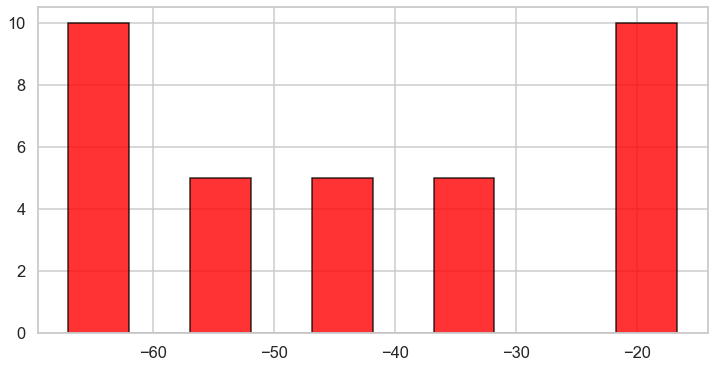

In [63]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(preds - labels_1, alpha = 0.8, color = 'r', edgecolor = 'black')


In [64]:
n = 0
k = 0
for n in range(5):
    print(f'Predição {preds[k]} e espessura real {labels_1[k]}')
    k+=1

Predição -0.32516491413116455 e espessura real 34.1772721679296
Predição -0.3252553939819336 e espessura real 34.1772721679296
Predição -0.32498955726623535 e espessura real 34.1772721679296
Predição -0.3248501420021057 e espessura real 34.1772721679296
Predição -0.3250104784965515 e espessura real 34.1772721679296


In [101]:
path_bab = r'data_barbara\Mapas_experimentais_(MEIS)//'
files_barbara  = [f for f in listdir(path_bab) if isfile(join(path_bab,f))]
values_reais = []
for file in files_barbara:
    file_name = path_bab + file
    values_reais.append(real_data(file_name))

In [102]:
df_real = pd.DataFrame(columns = np.arange(0,689))
df_real = df_real.append(values_reais, ignore_index = True)

In [108]:
df_real_1, labels_1 = limit_map(5,df_real,0)
df_real_2, labels_2 = limit_map(5,df_real,5)
df_real_3, labels_3 = limit_map(5,df_real,10)
df_real_4, labels_4 = limit_map(5,df_real,15)
df_real_5, labels_5 = limit_map(5,df_real,20)

In [112]:
x_real_1, l1 = data_to_keras_format(df_real_1, labels_1,info_1[0], info_1[1], type_data = 'test')
x_real_2, l2 = data_to_keras_format(df_real_2, labels_2,info_2[0], info_2[1], type_data = 'test')
x_real_3, l3 = data_to_keras_format(df_real_3, labels_3,info_3[0], info_3[1], type_data = 'test')
x_real_4, l4 = data_to_keras_format(df_real_4, labels_4,info_4[0], info_4[1], type_data = 'test')
x_real_5, l5 = data_to_keras_format(df_real_5, labels_5,info_5[0], info_5[1], type_data = 'test')

In [113]:
preds_reais = model_.predict([x_real_1,x_real_2,x_real_3,x_real_4,x_real_5]).flatten()

In [114]:
print(preds_reais)

[333.46014 343.06683 355.8482  345.94177 351.4653 ]


In [115]:
files_barbara

['EXPscan1_dL_0.75_thickness_52_frac_m1_0.6_frac_m2_0.4.dat',
 'EXPscan2_dL_0.76_thickness_48_frac_m1_0.59_frac_m2_0.41.dat',
 'EXPscan3_dL_0.765_thickness_40_frac_m1_0.56_frac_m2_0.44.dat',
 'EXPscan4_dL_0.76_thickness_41_frac_m1_0.57_frac_m2_0.43.dat']